In [1]:
import sys
sys.path.append("..")

In [2]:
import wfdb

from raccoon.utils.annotationutils import trigger_points

def read_record(path, sampto):
    record = wfdb.rdrecord(path, sampto=sampto)
    annotation = wfdb.rdann(path, 'atr', sampto=sampto)
    positions, labels = trigger_points(annotation, with_labels=True)
    return record, positions, labels

def read_records(directory, names, sampto):
    records, positions, labels = [], [],  []
    for name in names:
        path = "/".join([directory, name])
        record, pos, labs = read_record(path, sampto)
        records.append(record)
        positions.append(pos)
        labels.append(labs)
    return records, positions, labels

In [3]:
record_dir = "../physionet.org/files/mitdb/1.0.0"
test_path = '/'.join([record_dir, '106'])
train_names = ["100", "101", "102", "103", "104"]
sampto = None

train_records, train_positions, train_labels = read_records(record_dir, train_names, sampto)
test_record, test_positions, test_labels = read_record(test_path, sampto)

In [4]:
from raccoon.detectors import GarciaBerdonesDetector, SarlijaDetector, XiangDetector

gbd = GarciaBerdonesDetector(
    name = "Garcia-Berdones",
    batch_size = 32,
    window_size = 20,
    epochs = 3)

sd = SarlijaDetector(
    name = "Sarlija",
    batch_size = 32,
    window_size = 40,
    detection_size=20,
    epochs = 3)

xd = XiangDetector(
    name='Xiang',
    batch_size=32,
    window_size=40,
    detection_size=20,
    aux_ratio=5,
    epochs=3)

Using TensorFlow backend.
/home/Jonas.Chromik/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/Jonas.Chromik/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/Jonas.Chromik/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/Jonas.Chromik/.local/lib/python3.7/sit

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
gbd.train(train_records, train_positions)
sd.train(train_records, train_positions)
xd.train(train_records, train_positions)

Instructions for updating:
Use tf.cast instead.
Epoch 1/3
60935/60935 [==============================] - 88s 1ms/step - loss: 0.0096
Epoch 2/3
60935/60935 [==============================] - 88s 1ms/step - loss: 0.0079
Epoch 3/3
60935/60935 [==============================] - 85s 1ms/step - loss: 0.0080
Epoch 1/3
60933/60933 [==============================] - 413s 7ms/step - loss: 1.0292
Epoch 2/3
60933/60933 [==============================] - 435s 7ms/step - loss: 1.0292
Epoch 3/3
60933/60933 [==============================] - 421s 7ms/step - loss: 1.0292
Epoch 1/3
60933/60933 [==============================] - 149s 2ms/step - loss: 0.0069
Epoch 2/3
60933/60933 [==============================] - 145s 2ms/step - loss: 0.0041
Epoch 3/3
60933/60933 [==============================] - 144s 2ms/step - loss: 0.0040


In [6]:
gbd_ts = gbd.trigger_signal(test_record)
sd_ts = sd.trigger_signal(test_record)
xd_ts = xd.trigger_signal(test_record)

In [7]:
from raccoon.utils.triggerutils import signal_to_points

gbd_dets, gbd_certs = signal_to_points(gbd_ts, with_certainty=True)
sd_dets, sd_certs = signal_to_points(sd_ts, with_certainty=True)
xd_dets, xd_certs = signal_to_points(xd_ts, with_certainty=True)

In [8]:
from itertools import repeat
import pandas as pd

df = pd.concat([
    pd.DataFrame(zip(gbd_dets, gbd_certs, repeat(gbd.name))),
    pd.DataFrame(zip(sd_dets, sd_certs, repeat(sd.name))),
    pd.DataFrame(zip(xd_dets, xd_certs, repeat(xd.name)))])

df.columns = ['Position', 'Certainty', 'Detector']

/home/Jonas.Chromik/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


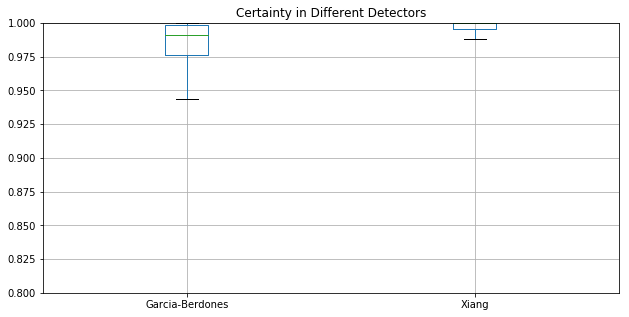

In [9]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

df.boxplot(
    column='Certainty', by='Detector', ax=ax,
    showfliers=False)

ax.set_ylim(0.8,1)
ax.set_xlabel("")
ax.set_title("Certainty in Different Detectors")
fig.suptitle("")

ax

In [10]:
# fig.savefig('../generated/figures/impact_detector.pdf', format='pdf', bbox_inches = 'tight', pad_inches = 0.1)